In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.output_parsers import StrOutputParser
from typing import TypedDict
from dotenv import load_dotenv

In [2]:
load_dotenv()

model = ChatOpenAI()

parser = StrOutputParser()

In [6]:
class CricketState(TypedDict):

    balls : int
    runs : int
    fours : int
    sixes : int

    bpb : float
    bp : float
    sr : float

    summary : str

In [21]:
def calculate_bpb(state : CricketState)->CricketState:

    balls = state['balls']
    fours = state['fours']
    sixes = state['sixes']

    bpb = balls/(fours + sixes)

    #state['bpb'] = bpb

    return {'bpb':bpb}

def calculate_bp(state : CricketState)->CricketState:

    runs = state['runs']
    fours = state['fours']
    sixes = state['sixes']

    bp = (((fours*4) + (sixes*6))/runs)*100

    state['bp']=bp

    return {'bp':bp}

def calculate_sr(state:CricketState)->CricketState:

    runs=state['runs']
    balls = state['balls']

    sr = (runs/balls)*100

    #state['sr'] = sr

    return {'sr':sr}

def summary(state:CricketState)->CricketState:

    bpb = state['bpb']
    sr = state['sr']
    bp = state['bp']

    summary = f"""
    Strike Rate - {sr} \n
    Balls per boundary - {bpb} \n
    Boundary percent - {bp}
    """ 

    return {'summary':summary}

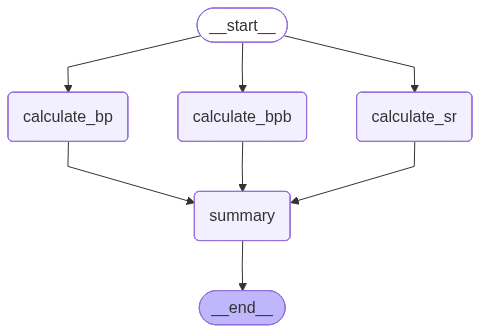

In [22]:
graph = StateGraph(CricketState)

graph.add_node('calculate_bpb',calculate_bpb)
graph.add_node('calculate_bp',calculate_bp)
graph.add_node('calculate_sr',calculate_sr)
graph.add_node('summary',summary)

graph.add_edge(START,'calculate_bpb')
graph.add_edge(START,'calculate_bp')
graph.add_edge(START,'calculate_sr')

graph.add_edge('calculate_bpb','summary')
graph.add_edge('calculate_bp','summary')
graph.add_edge('calculate_sr','summary')

graph.add_edge('summary',END)

workflow = graph.compile()

workflow

In [23]:
intial_state = {
    'runs': 100,
    'balls': 50,
    'fours': 6,
    'sixes': 4
}

final_state=workflow.invoke(intial_state)

final_state

{'balls': 50,
 'runs': 100,
 'fours': 6,
 'sixes': 4,
 'bpb': 5.0,
 'bp': 48.0,
 'sr': 200.0,
 'summary': '\n    Strike Rate - 200.0 \n\n    Balls per boundary - 5.0 \n\n    Boundary percent - 48.0\n    '}

In [24]:
final_state['summary']

'\n    Strike Rate - 200.0 \n\n    Balls per boundary - 5.0 \n\n    Boundary percent - 48.0\n    '